# Hermite 12 parameters fit for autocorrelation function inference
Here we reproduced the inference for model1 using the fit coeffincients of hermite 12-order function fit on the autocorrelation function of model1.\
We tried with 100k simulations to evaluate the potential of Hermite's approximation but we did not see improvement in the inference quality nor its time used for training; the only improvement is in the dataset size. \
With an i7-8700k we get approximately 0.023s/it, so 100k simulations with 10 threads is more or less 45 minutes of work, maybe improvement would be trying different
simulations parameters and different sized datasets to feed the neural network for inference. \
Here we disabled saving of datasets and posterior for ease of reproducing without cluttering the database of results.

In [50]:
import numba as nb
import numpy as np
import torch
import torch
import numpy as np
import time
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from scipy.optimize import curve_fit


#!pip install numba icc_rt rocket-fft

@nb.njit(fastmath=True)
def cumulative_trapezoid(y, x):
    """
    Compute the cumulative trapezoidal integral of y with respect to x.

    Parameters:
    y : numpy.ndarray
        Array of y values.
    x : numpy.ndarray
        Array of x values (must have the same shape as y).

    Returns:
    numpy.ndarray
        Array of cumulative trapezoidal integrals.
    """
    integral = np.zeros_like(y)
    for i in range(1, len(x)):
        integral[i] = integral[i-1] + 0.5 * (y[i] + y[i-1]) * (x[i] - x[i-1])
    return integral


@nb.njit(fastmath=True)
def jit_fft(x,f):
    return np.fft.fft(x,f)

@nb.njit(fastmath=True)
def jit_fft2(x):
    return np.fft.fft(x)

@nb.njit(fastmath=True)
def jit_fftfreq(x,d):
    return np.fft.fftfreq(x,d)

@nb.njit(fastmath=True)
def jit_ifft(x):
    return np.fft.ifft(x)
    
@nb.njit(fastmath=True)
def corr(x,y,nmax,dt=False):
    assert len(x)==len(y)

    n=len(x)
    fsize=2**int(np.ceil(np.log2(2*n-1)))

    xp=x-np.mean(x)
    yp=y-np.mean(y)

    cfx=jit_fft(xp,fsize)
    cfy=jit_fft(yp,fsize)
    
    if dt != False:
        freq = jit_fftfreq(n, d=dt)
        idx = np.where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr = jit_ifft(sf).real / n

    return corr[:nmax]
@nb.njit(fastmath=True)
def D(X, D1, D2, dt):
    #g = np.random.normal(0, dt**0.5) #random uguale per posizioni e forze scale=dt**0.5
    g = np.random.normal(loc=0.0, scale=dt**0.5, size=(len(X), 2)) 
    result = np.empty((len(X), 2))
    for i in range(len(X)):
        result[i, 0] = np.sqrt(2*D1)*g[i,0]
        result[i, 1] = np.sqrt(2*D2)*g[i,1]
    return result

@nb.njit(fastmath=True)
def force(X, d, μ, k, τ):
    result = np.empty((len(X), 2))
    for i in range(len(X)):
        x = X[i]
        result[i, 0] = μ * (-k * x[0] - d * x[0]**3+ x[1]) #x update
        result[i, 1] = -x[1] / τ #fx update
    return result

@nb.njit(fastmath=True)
def dx(state, dt, d, μ, k, τ, D1, D2):
    Fs =force(state, d, μ, k, τ)
    Ds=D(state, D1, D2, dt)
    """
    Ds=np.empty((Fs.shape[0], 2))
    for i in range(Fs.shape[0]):
        Ds[i,0]= np.sqrt(2*D1) * random_values[i] 
        Ds[i,1]=np.sqrt(2*D2) * random_values[i]
            """

    return dt * Fs + Ds

@nb.njit(fastmath=True)
def simulate(tlist, initial_position, oversampling, prerun, d, μ, k, τ, D1, D2, dt):
    state = initial_position.copy()
    dto = dt / oversampling
    
    #random_values =  np.random.normal(0, dt**0.5, len(tlist) * oversampling) 

    # Pre-equilibration
    for j in range(prerun * oversampling):
        state += dx(state, dt, d, μ, k, τ, D1, D2)
    
    # Start recording
    data = np.zeros((len(tlist),state.shape[0],state.shape[1])) 
    forces = np.zeros((len(tlist),state.shape[0],state.shape[1]))
    for i in range(len(tlist)):
        data[i, :, :] = state
        forces[i, :, :] = force(state, d, μ, k, τ)
        for j in range(oversampling):
            state += dx(state, dto, d, μ, k, τ, D1, D2)
        data[i, :, :] = state

    #data[-1, :, :] = state
    #forces[-1, :, :] = force(state, d, μ, k, τ) 
    return data, forces

@nb.njit(fastmath=True)
def entropy(x, f, tlist, dt, D1):
    dx = x[1:]-x[:-1]
    #print(dx)
    #print(x[:-1])
    Fs=(f[1:]+f[:-1])/2
    #print(Fs)
    S=np.sum(Fs*dx)/(D1*(tlist[-1]-1)*dt)
    return S

@nb.njit(fastmath=True)
def hermite_p(n, x):
    """
    Compute the nth Hermite polynomial at x using recurrence relation.
    
    Parameters:
    n (int): The order of the Hermite polynomial.
    x (float or numpy.ndarray): The point(s) at which to evaluate the polynomial.
    
    Returns:
    float or numpy.ndarray: The value of the nth Hermite polynomial at x.
    """
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 2.0 * x
    else:
        H_n_minus_2 = np.ones_like(x)  # H_0(x) = 1
        H_n_minus_1 = 2.0 * x          # H_1(x) = 2x
        for i in range(2, n + 1):
            H_n = 2.0 * x * H_n_minus_1 - 2.0 * (i - 1) * H_n_minus_2
            H_n_minus_2 = H_n_minus_1
            H_n_minus_1 = H_n
        return H_n

@nb.njit(fastmath=True)
def factorial(n):
    """
    Compute the factorial of a non-negative integer n using a loop.
    
    Parameters:
    n (int): A non-negative integer whose factorial is to be computed.
    
    Returns:
    int: The factorial of the input number n.
    """
    if n < 0:
        raise ValueError("Factorial is not defined for negative numbers.")
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

@nb.njit(fastmath=True)
def phi(n,x):
    x_sdv = np.std(x)
    z = x / x_sdv
    return np.exp(-z**2/2)*hermite_p(n,x)*(2**n*factorial(n)*np.sqrt(np.pi))**(-1/2)

@nb.njit(fastmath=True)
def power_spectrum(time_series, sampling_rate):
    """
    Compute the power spectrum of a time series.

    Parameters:
    time_series (numpy array): The input time series data.
    sampling_rate (float): The sampling rate of the time series data.

    Returns:
    freqs (numpy array): The array of frequency bins.
    power_spectrum (numpy array): The power spectrum of the time series.
    """

    # Compute the FFT
    X = jit_fft2(time_series)
    N = len(X)
    freqs = jit_fftfreq(N, 1/sampling_rate)

    # Compute the power spectrum
    power_spectrum = np.abs(X)**2 / N

    # Return only the positive frequencies and their power
    pos_indices = np.where(freqs >= 0)
    freqs = freqs[pos_indices]
    power_spectrum = power_spectrum[pos_indices]

    return freqs, power_spectrum

In [51]:
import numpy as np
from scipy.optimize import curve_fit

# Define other necessary functions here...
#@nb.njit(fastmath=True)
def hermite_model(t, *coeffs, dt):
    f_bar = np.mean(power_spectrum(t, dt)[1])
    sqrt_f_bar = np.sqrt(f_bar)
    result = np.zeros_like(t)
    
    for i, a_i in enumerate(coeffs):
        result += a_i * sqrt_f_bar * phi(i, f_bar * t)#, (f_bar*t)/np.std(f_bar*t))
    return result

# wrapper for curve_fit
def hermite_model_for_curve_fit(t, dt, *coeffs):
    return hermite_model(t, *coeffs, dt=dt)

def simulator_sbi2(pars, dt, oversampling, prerun, Npts, d=0, k=1): 
    μ = 1
    kBT = 1
    D1 = kBT * μ
    ϵ = np.float64(pars[0])
    τ = np.float64(pars[1])
    D2 = ϵ**2 / τ
    d = np.float64(pars[2])
    tau = dt * Npts
    tlist = np.linspace(0. + dt / 2., tau, Npts)
    initial_position = np.zeros(shape=(1, 2), dtype=np.float64)

    data, forces = simulate(tlist, initial_position=initial_position, oversampling=oversampling, 
                            prerun=prerun, d=d, μ=μ, k=k, τ=τ, D1=D1, D2=D2, dt=dt)
    x = data[:, 0, 0]
    f_int = (forces[:, 0, 0] / μ + k * x)
    
    
    # Correlation functions
    Cxx = corr(x, x, len(tlist), dt=dt)
    Cfx = corr(f_int, x, len(tlist), dt=dt)

    x_sdv = np.std(x)
    phi0 = phi(0, x)
    phi2 = phi(2, x)
    phi4 = phi(4, x)

    stat_1 = x_sdv
    stat_2 = np.mean(phi0 / np.sqrt(x_sdv))
    stat_3 = np.mean(phi2 / np.sqrt(x_sdv))
    stat_4 = np.mean(phi4 / np.sqrt(x_sdv))

    initial_guess = np.zeros(12)  # Ensure the guess has the same length as the number of coefficients

    # Use the wrapper function for curve_fit
    t_corr = 10
    idx_corr = np.where(tlist < t_corr)[0]
    wrapped_model = hermite_model_for_curve_fit(t=tlist[idx_corr], dt=dt)
    fitted_coeff, _ = curve_fit(lambda t, *coeffs: hermite_model_for_curve_fit(t, dt, *coeffs), tlist[idx_corr], Cxx[idx_corr], p0=initial_guess)
  
    
    npcombo = np.concatenate((np.array([stat_1, stat_2, stat_3, stat_4]), fitted_coeff))
    
    return npcombo

# Your simulate and other necessary functions should be defined here...

In [52]:
low_tensor = torch.tensor([0,0.01,0])
high_tensor = torch.tensor([2,2,1])

dt = 1e-2
oversampling = 5
prerun = 1e3
Npts = 5e4


def simulator_to_sbi(pars):
    return simulator_sbi2(np.array(pars), dt, oversampling, int(prerun),int(Npts))



prior_sbi = utils.BoxUniform(low=low_tensor, high=high_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator_to_sbi, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [61]:
num_simulations=30000
num_workers=10
sim_batch_size=int(num_simulations/(num_workers*10))

#to use parallel processing you need python<3.11
start=time.time()
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations, 
                            num_workers=num_workers, simulation_batch_size=sim_batch_size)
end=time.time()

#bsize = 10, nworkers=10, ~ 0.62s/it
#new sim with 100 batches ~0.29s/it, same with 10 batches

print('mean time per iteration: ', (end-start)/num_simulations)

Running 100000 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

mean time per iteration:  0.0232863449215889


In [62]:
from parsing_functions import save_pickle_data

# saving dataset for future use
save_dir = 'saved_datasets/hermite/'
data = {
    'theta': theta,
    'x': x,
    'num_simulations': num_simulations,
    'Npts': Npts,
    'dt': dt,
    'oversampling': oversampling,
    'prerun': prerun,
    'low_tensor': low_tensor,
    'high_tensor': high_tensor,
    'features': 'hermite'  # Indicates the type of the data
}

#save_pickle_data(data=data, folder_path=save_dir)

Saved dataset at saved_datasets/hermite/dataset_85629f6afaaf8a587c15d67250a2a477.pickle



'saved_datasets/hermite/dataset_85629f6afaaf8a587c15d67250a2a477.pickle'

In [63]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta, x)
start = time.time()
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)
end = time.time()
print('\n time passed for convergence: ', end-start)

 Neural network successfully converged after 179 epochs.
 time passed for convergence:  3197.7266974449158


In [64]:
#saving generated posterior from SBI
posterior_dir = 'saved_posteriors/'

data_posterior = {
    'posterior': posterior,
    'num_simulations': num_simulations,
    'Npts': Npts,
    'dt': dt,
    'oversampling': oversampling,
    'prerun': prerun,
    'low_tensor': low_tensor,
    'high_tensor': high_tensor,
    'features': 'hermite'# Indicates the type of the data
}

#save_pickle_data(data=data_posterior, folder_path=posterior_dir)

Saved dataset at saved_posteriors/posterior_85629f6afaaf8a587c15d67250a2a477.pickle



'saved_posteriors/posterior_85629f6afaaf8a587c15d67250a2a477.pickle'

In [67]:
theta_true = prior.sample((1,))
print(theta_true)
# generate our observation

x_obs = simulator_to_sbi(theta_true[0])
samples = posterior.sample((10_000_000,), x=x_obs)

tensor([[0.5498, 1.8279, 0.9441]])


Drawing 10000000 posterior samples:   0%|          | 0/10000000 [00:00<?, ?it/s]

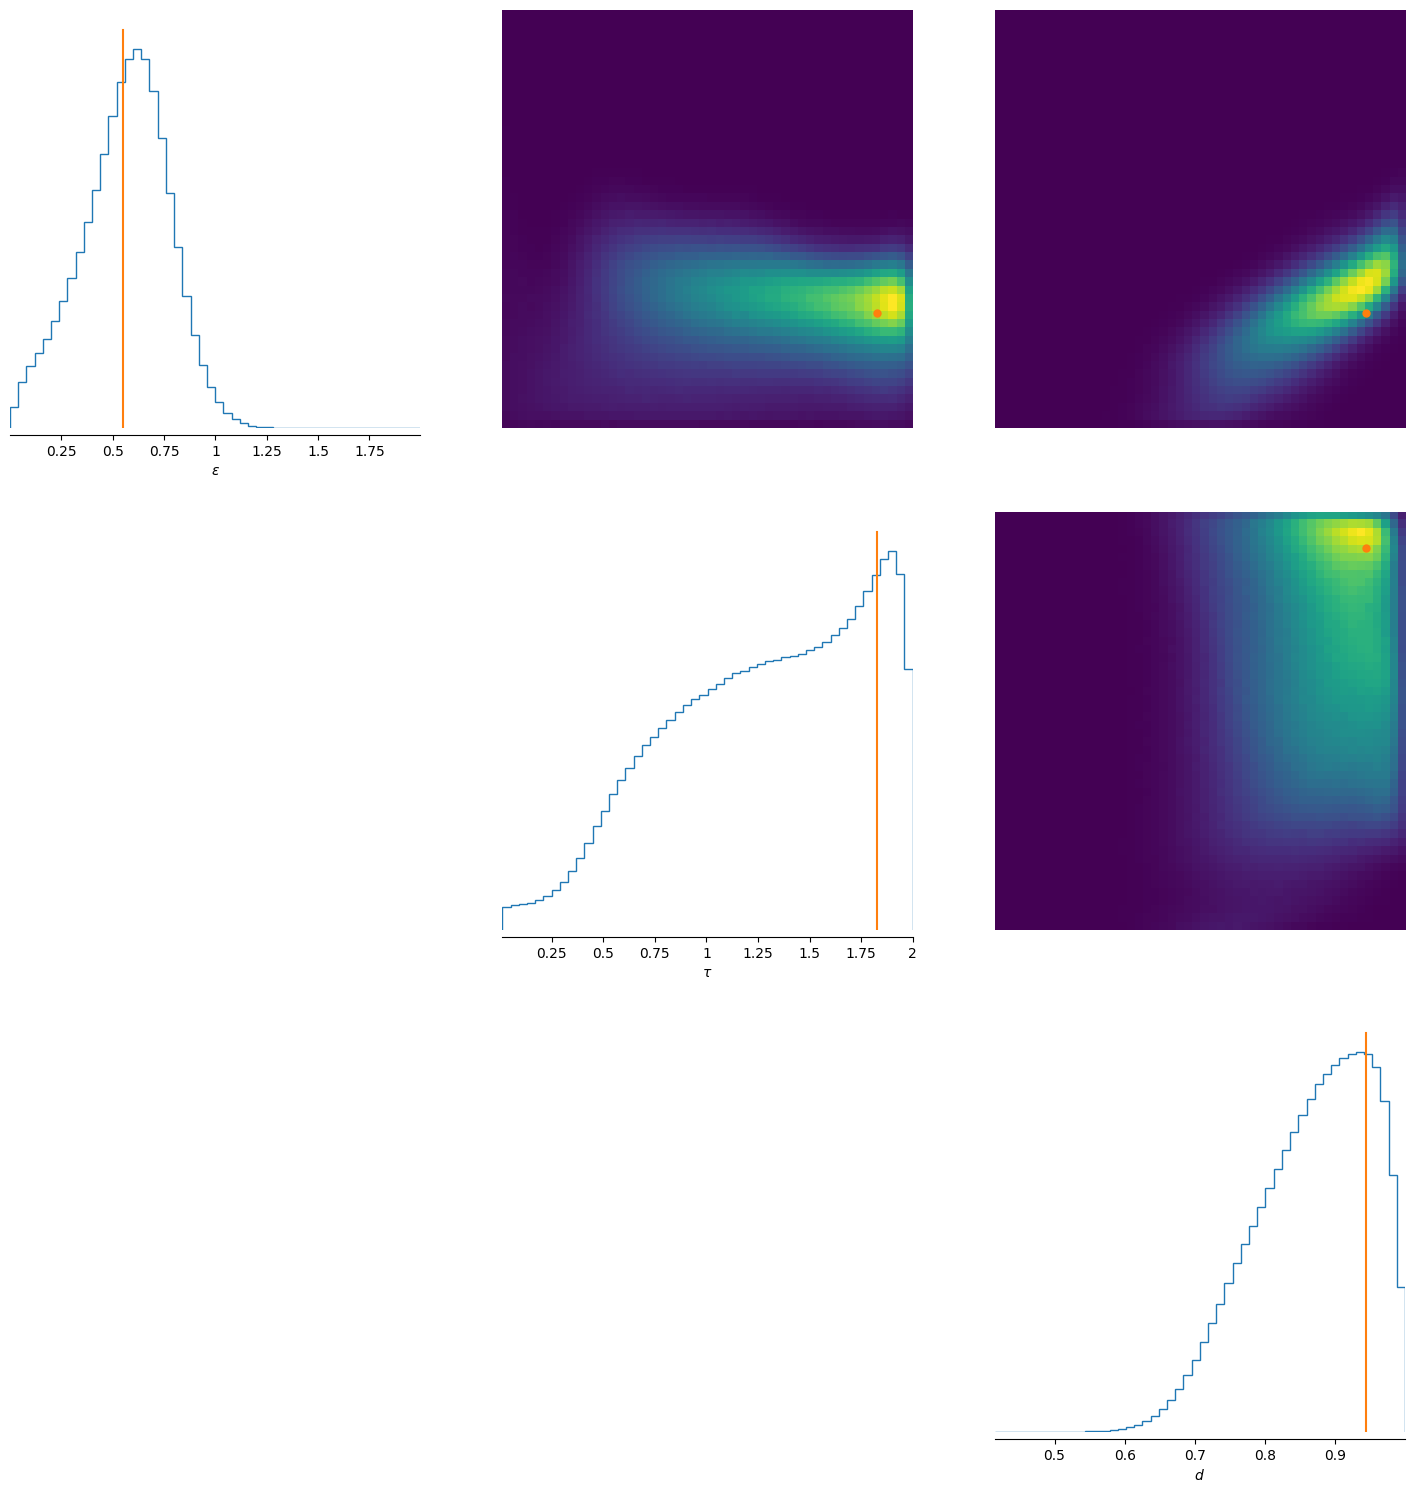

In [68]:
from sbi import analysis
from sbi import utils as utils

fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(18, 18),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])

#fig.savefig('hermitean1Mpar.png', dpi=600)